# Uncertain CF with a discrete probability distribution

This notebook exemplifies how to account for the archetype uncertainty with discrete probability distributions using the library _presamples_. A similar procedure could be used to integrate other sources of uncertainty.

In [73]:
import brightway2 as bw
import presamples as ps
import pandas as pd
import numpy as np
import random
import scipy
import pyprind
import seaborn as sns
import matplotlib.pyplot as plt
from ulcarchetype.utils import get_cf_info
from ulcarchetype.utils import minmax_archetype

we need a project with ecoinvent, since we're using an ecoinvent activity for the example. 

In [3]:
bw.projects.set_current('uncertain archetype III')

In [4]:
assert 'biosphere3' in bw.databases

lets create some samples

### find elementary flows used in ecoinvent.

At the time this was written, presamples breaks if you use elementary flows that are not in the database you are exploring. 

In [9]:
ecoinvent_act = bw.Database('ei_36con').random()
ecoinvent_lca = bw.LCA({ecoinvent_act:1})
ecoinvent_lca.lci()

In [10]:
ecoinvent_elementary_flows = [code for database,code in ecoinvent_lca.biosphere_dict]

## creating samples for _presamples_


In [8]:
resp_inorg_deterministic = ('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics')

In [21]:
nsamples=5000

To avoid a computing error we need to erase from our samples the cases that are not present in the database being tested (ecoinvent)

In [11]:
# get method cf
cf_df = get_cf_info(resp_inorg_deterministic)

In [12]:
cf_df.sample(3)

,database,code,name,amount,unit,type,compartment,subcompartment
21,biosphere3,3268d8df-59cc-4740-a89f-dee8355ad7c3,Sulfur trioxide,0.000008,kilogram,emission,air,None
0,biosphere3,2b50f643-216a-412b-a0e5-5946867aa2ed,Ammonia,0.000021,kilogram,emission,air,"low population density, long-term"
16,biosphere3,fd7aa71c-508c-480d-81a6-8052aad92646,Sulfur dioxide,0.000008,kilogram,emission,air,None


In [13]:
len(cf_df)

23

In [ ]:
# filter out those not present in ecoinvent

In [14]:
cf_df = cf_df[cf_df.code.isin(ecoinvent_elementary_flows)]

In [15]:
len(cf_df)

21

In [17]:
cf_range = minmax_archetype(cf_df)

In [112]:
cf_range

,code,name,amount,minimum,maximum,compartment
0,"(biosphere3, 87883a4e-1e3e-4c9d-90c0-f1bea36f8...",Ammonia,0.000021,1.400000e-05,0.000021,air
1,"(biosphere3, c1b91234-6f24-417b-8309-46111d09c...",Nitrogen oxides,0.000002,2.100000e-07,0.000002,air
2,"(biosphere3, 21e46cb8-6233-4c99-bac3-c41d2ab99...","Particulates, < 2.5 um",0.000238,3.017570e-06,0.000238,air
3,"(biosphere3, fd7aa71c-508c-480d-81a6-8052aad92...",Sulfur dioxide,0.000008,9.900000e-07,0.000008,air


***

In [27]:
cf_possible_values={}

In [32]:
for g in cf_df.loc[cf_df.subcompartment.isna(),['code','name','compartment']].itertuples():
    # list of possible values
    possible_values = cf_df.loc[(cf_df.name==g.name)&(cf_df.compartment==g.compartment),'amount'].tolist()
    
    # create a dict with the code as key and the possible values as ... values
    if len(possible_values)>1:
        cf_possible_values[('biosphere3',g.code)] = cf_df.loc[(cf_df.name==g.name)&(cf_df.compartment==g.compartment),'amount'].tolist()
        
    # create samples using random samples of possible values
    samples = np.array([random.choices(values,k=nsamples) for key,values in cf_possible_values.items()])
    indices = [k for k in cf_possible_values.keys()]

    # do some data validation
    for i in indices:
        assert i in bw.Database('biosphere3')
    assert samples.shape[0]==len(indices)

    scenario_matrix_data=[(samples,indices,'cf')]

the results that we need for presamples are:
- an array containing samples for each (elementary flow, compartment)
- the codes that point to these pairs (elementary flow, compartment)
- the string `cf` to point that this data is for the characterisation factor matrix

In [33]:
scenario_matrix_data

[(array([[2.10000e-05, 2.10000e-05, 2.10000e-05, ..., 2.10000e-05,
          2.10000e-05, 2.10000e-05],
         [2.10000e-07, 1.60000e-06, 2.10000e-07, ..., 1.60000e-06,
          2.10000e-07, 2.10000e-07],
         [2.38497e-04, 2.38497e-04, 2.38497e-04, ..., 3.01757e-06,
          3.01757e-06, 2.38497e-04],
         [8.00000e-06, 8.00000e-06, 8.00000e-06, ..., 9.90000e-07,
          9.90000e-07, 9.90000e-07],
         [8.00000e-06, 8.00000e-06, 8.00000e-06, ..., 8.00000e-06,
          8.00000e-06, 8.00000e-06]]),
  [('biosphere3', '87883a4e-1e3e-4c9d-90c0-f1bea36f8014'),
   ('biosphere3', 'c1b91234-6f24-417b-8309-46111d09c457'),
   ('biosphere3', '21e46cb8-6233-4c99-bac3-c41d2ab99498'),
   ('biosphere3', 'fd7aa71c-508c-480d-81a6-8052aad92646'),
   ('biosphere3', '3268d8df-59cc-4740-a89f-dee8355ad7c3')],
  'cf')]

we give it a name and store it. 

In [36]:
presamples_name_d = f"{'|'.join(resp_inorg_deterministic)}|{nsamples} samples|discrete"
presamples_name_d

'ILCD 2.0 2018 midpoint|human health|respiratory effects, inorganics|5000 samples|discrete'

In [37]:
# create package
cfsamples_id_discrete, cfsamples_fp_discrete = ps.create_presamples_package(matrix_data=scenario_matrix_data,
                                                                            name=presamples_name_d,
                                                                            seed=1)

## test

In [38]:
train_de=[act for act in bw.Database('ei_36con') if (act['name']=='transport, passenger train') and (act['location']=='DE')][0]

In [42]:
deterministic_lca = bw.LCA({train_de:1},resp_inorg_deterministic)

In [43]:
deterministic_lca.lci()
deterministic_lca.lcia()

In [40]:
mc = bw.MonteCarloLCA({train_de:1},resp_inorg_deterministic,presamples=[cfsamples_fp_discrete])

In [41]:
next(mc)

2.4792476326755683e-09

In [47]:
assert deterministic_lca.biosphere_dict == mc.biosphere_dict
assert deterministic_lca.activity_dict == mc.activity_dict

In [70]:
results = []
for _ in pyprind.prog_bar(range(2000)):
    next(mc)
    result_determ = (deterministic_lca.characterization_matrix.dot(mc.inventory)).sum()
    results.append((mc.score,result_determ))

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:49


In [71]:
comparison_df = pd.DataFrame(results,columns=['discrete','deterministic'])

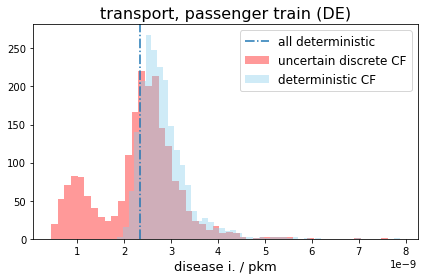

In [72]:
sns.distplot(comparison_df['discrete'],color="red", label="uncertain discrete CF",kde=False)
sns.distplot(comparison_df.deterministic,color="skyblue", label="deterministic CF",kde=False)
plt.title('transport, passenger train (DE)',fontsize=16)
plt.axvline(deterministic_lca.score,ls="-.",label='all deterministic');
plt.legend(fontsize=12);
plt.xlabel('disease i. / pkm',fontsize=13)
plt.tight_layout()
plt.savefig('train_results_for_presentation_discrete.png',dpi=300)

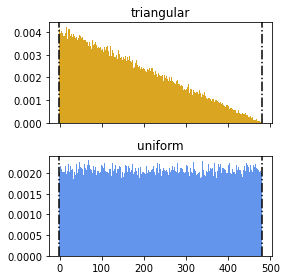

In [111]:
f,a = plt.subplots(nrows=2,ncols=1,figsize=(4,4),sharex=True)

a[0].hist(np.random.triangular(-0.8, -0.8, 480, 100000), bins=200,density=True,color='goldenrod');
a[1].hist(np.random.uniform(-0.8,480,100000), bins=200,density=True,color='cornflowerblue');
a[0].set_title('triangular');
a[1].set_title('uniform');

a[0].axvline(-0.8,ls='-.',color='k')
a[0].axvline(480,ls='-.',color='k')
a[1].axvline(-0.8,ls='-.',color='k')
a[1].axvline(480,ls='-.',color='k')
plt.tight_layout()